In [5]:
# Put file path as a string here
CIFAR_DIR = ('C:\\Users\\akkim\\Desktop\\cifar-10-batches-py\\')

In [6]:
#The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle. 

# ** Load the Data. Use the Code Below to load the data: **

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [7]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [8]:
all_data = [0,1,2,3,4,5,6]

In [9]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [10]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [11]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [ ]:
#** Why the 'b's in front of the string? **
#Bytes literals are always prefixed with 'b' or 'B'; they produce an instance of the bytes type instead of the str type. They may only contain ASCII characters; bytes with a numeric value of 128 or greater must be expressed with escapes.

#https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal

In [12]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [42]:
#Loaded in this way, each of the batch files contains a dictionary with the following elements:
#* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. 
#The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.
#The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first 
#row of the image.

#* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

#The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

#* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. 
#For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [13]:
### Display a single image using matplotlib.

##** Grab a single image from data_batch1 and 

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [14]:
X = data_batch1[b"data"] 

In [15]:
#10000 images, 32x32 picture, and in 3 bits of color..
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [57]:

X[0].max()

255

In [17]:
(X[0]/255).max()

1.0

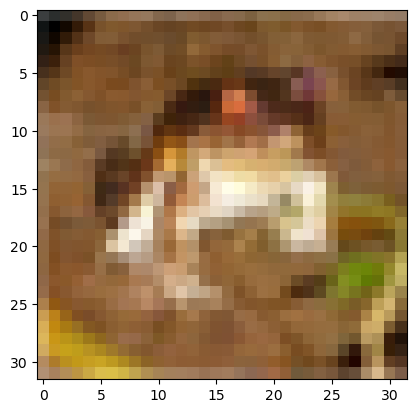

In [18]:
plt.imshow(X[0])

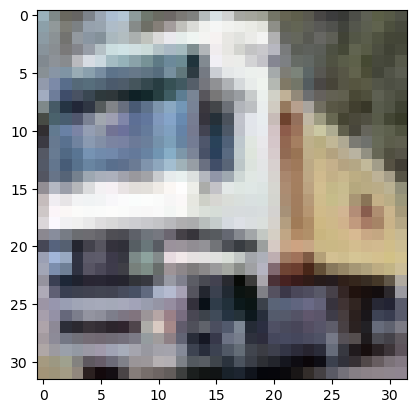

In [19]:
plt.imshow(X[1])

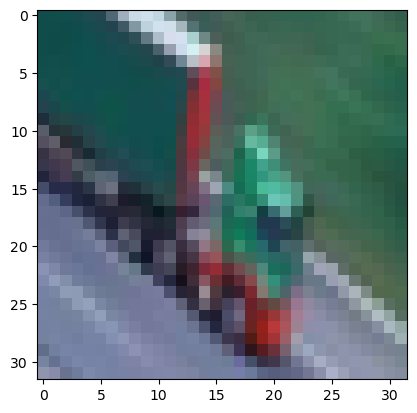

In [20]:
plt.imshow(X[50])

In [52]:
# Helper Functions for Dealing With Data.

#** Use the provided code below to help with dealing with grabbing the next batch once you've gotten ready to create the Graph Session.
#Can you break down how it works? **

In [21]:
#10 possible labels.. we dont look at labels as numbers like car = 1 horse = 3??
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [58]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

#we going to look from x from 0 to 100.. jst the first 100 images instead of 1000.. and then the images will be 32x32 x3
        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y
#x is the photo going in and y is the label from the one hot encoder..eg if hose is 0 we get [1,0,0,0...]

In [59]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [23]:
## Creating the Model

#* Import tensorflow **
import tensorflow as tf

In [65]:
#** Create 2 placeholders, x and y_true. Their shapes should be: **

#* x shape = [None,32,32,3]
#* y_true shape = [None,10]

import tensorflow as tf

# Create placeholder for input x
x = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

# Create placeholder for true labels y_true
y_true = tf.keras.Input(shape=(10,), dtype=tf.float32)



In [60]:
#** Create one more placeholder called hold_prob. No need for shape here. 
#This placeholder will just hold a single probability for the dropout. **

In [67]:
import tensorflow as tf

# Create a placeholder for hold_prob using tf.keras.Input

#In this code:

#hold_prob is created as an input placeholder using tf.keras.Input.
#shape=() specifies that hold_prob is a scalar (0-dimensional tensor).
#dtype=tf.float32 specifies the data type of hold_prob as float32.
#Choose the approach that best fits your use case, whether it's creating a constant value (using tf.Variable) or a placeholder for input data (using tf.keras.Input).
hold_prob = tf.keras.Input(shape=(), dtype=tf.float32)

In [26]:
### Helper Functions

** Grab the helper functions from MNIST with CNN (or recreate them here yourself for a hard challenge!). You'll need: **

* init_weights
* init_bias
* conv2d
* max_pool_2by2
* convolutional_layer
* normal_full_layer

SyntaxError: unterminated string literal (detected at line 3) (1494755921.py, line 3)

In [68]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)


#data coming is 32x32x3.. 
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [71]:
### Create the Layers

#** Create a convolutional layer and a pooling layer as we did for MNIST. **
#** Its up to you what the 2d size of the convolution should be, but the last two digits need to be 3 and 32 because of the 
#3 color channels and 32 pixels. So for example you could use:**

convo_1 = convolutional_layer(x,shape=[4,4,3,32])

AttributeError: module 'tensorflow' has no attribute 'truncated_normal'

In [90]:
from tensorflow.keras.layers import Conv2D

def convolutional_layer(input_layer, filters, kernel_size, activation='relu'):
    # Create a convolutional layer using Keras
    conv_layer = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
    
    # Apply the convolutional layer to the input
    output = conv_layer(input_layer)
    
    return output

In [91]:
from tensorflow.keras.layers import MaxPooling2D

def max_pool_2by2(x):
    # Create a MaxPooling2D layer
    pooling_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')
    # Apply max pooling to the input
    output = pooling_layer(x)
    return output

In [93]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

convo_1 = convolutional_layer(x, filters=32, kernel_size=(4, 4))
convo_1_pooling = max_pool_2by2(convo_1)

In [ ]:
** Create the next convolutional and pooling layers.  The last two dimensions of the convo_2 layer should be 32,64 **

In [94]:
# Assuming you have defined the convolutional_layer function

# Define the second convolutional layer
convo_2 = convolutional_layer(convo_1_pooling, filters=64, kernel_size=(4, 4))

# Apply max pooling to the output of the second convolutional layer
convo_2_pooling = max_pool_2by2(convo_2)

In [ ]:
** Now create a flattened layer by reshaping the pooling layer into [-1,8 \* 8 \* 64] or [-1,4096] **

In [85]:
8*8*64

4096

In [101]:
from tensorflow.keras import layers

# Reshape the Keras tensor using Keras functions
from tensorflow.keras import layers

# Reshape the Keras tensor using Keras functions
convo_2_flat = layers.Reshape((-1, 8 * 8 * 64))(convo_2_pooling)

In [ ]:
** Create a new full layer using the normal_full_layer function and passing 
in your flattend convolutional 2 layer with size=1024. (You could also choose to reduce this to something like 512)**

In [96]:
from tensorflow.keras import layers

# Assuming normal_full_layer is a custom function that creates a fully connected layer
# Define the fully connected layer using Keras layers
full_layer_one = layers.Dense(1024, activation='relu')(convo_2_flat)

In [ ]:
** Now create the dropout layer with tf.nn.dropout, remember to pass in your hold_prob placeholder. **

In [102]:
from tensorflow.keras.layers import Dropout

# Define the dropout layer using Keras layers
full_one_dropout = Dropout(rate=0.1)(full_layer_one)

In [ ]:
** Finally set the output to y_pred by passing in the dropout layer into the normal_full_layer function. 
The size should be 10 because of the 10 possible labels**

In [103]:
from tensorflow.keras.layers import Dense

# Define the fully connected layer using Keras layers
y_pred = Dense(units=10, activation='softmax')(full_one_dropout)
y_pred

<KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_53>

In [ ]:
### Loss Function

** Create a cross_entropy loss function **

In [128]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

In [133]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Define the input shape
input_shape = (64, 64, 3)  # Example input shape
num_classes = 10  # Example number of classes

# Define your model
inputs = Input(shape=input_shape)
outputs = Dense(num_classes, activation='softmax')(inputs)
model = Model(inputs=inputs, outputs=outputs)

In [122]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the input shape
input_shape = (64, 64, 3)  # Assuming input images of size 64x64 with 3 color channels

# Define the input tensor
input_tensor = Input(shape=input_shape)

# Define the layers of your model
# Example layers...
conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_tensor)
# Add more layers...

# Define the output tensor
# Example output...
output_tensor = Dense(10, activation='softmax')(conv1)  # Assuming 10 classes for classification

# Define your model
model = Model(inputs=input_tensor, outputs=output_tensor)

In [134]:
from tensorflow.keras.optimizers import Adam

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])